In [1]:
import xarray as xr
import numpy  as np
# import seaborn as sns
import proplot as plot
import pandas as pd
import matplotlib.pyplot as plt

2021.04.19

进行分区之后的绘制脚本，分区在此前已经由cdo完成

计算采用同目录下的 timeseries_count.py 使用import进行导入之后使用，其中进行了五天的滑动平均

将计算结果保存到 partial_mean partial_std 之中，作为字典整理为pandas，进行timeseries的绘图

In [2]:
from timeseries_count import *

# get partial mask_res collect into a dict
partial_list = ["NE", "NC", "YZ", "SW"]
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_t2m"
file_ref= "ydaymean_mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
file_vr = "ydaymean_mask_mean_t2m_98-17_VR.nc"
file_rcm = "ydaymean_mask_mean_t2m_98-17_RCM.nc"
partial_mean = {} # partial mask_res
partial_std = {} # partial mask_res
for i in partial_list:
    path_in_partial = path_in + "/" + i + "/mask_res_dayofyear" # refine path
    print(path_in_partial)
    partial_mean[i] = mean_count(path_in_partial, file_ref, "tm", file_vr, "t2m", file_rcm, "t2m")
    partial_std[i] = std_count(path_in_partial, file_ref, "tm", file_vr, "t2m", file_rcm, "t2m")

/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_t2m/NE/mask_res_dayofyear
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_t2m/NC/mask_res_dayofyear
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_t2m/YZ/mask_res_dayofyear
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_t2m/SW/mask_res_dayofyear


In [3]:
# pd.concat([temp_obs['cn051'], temp_vr['vr'], temp_rcm['rcm']], axis=1)

In [4]:
mean_temp = {}
std_temp  = {}
time_idx = pd.date_range(start = "2003-04-01", end = "2003-08-31",freq='d') # add time coords

for i in partial_list:
    temp_obs = partial_mean[i][0].to_dataframe().rename(columns={"tm":"cn051"})
    temp_vr  = partial_mean[i][1].to_dataframe().rename(columns={"t2m":"vr"})
    temp_rcm = partial_mean[i][2].to_dataframe().rename(columns={"t2m":"rcm"})

    std_obs = partial_std[i][0].to_dataframe().rename(columns={"tm":"cn051"})
    std_vr  = partial_std[i][1].to_dataframe().rename(columns={"t2m":"vr"})
    std_rcm = partial_std[i][2].to_dataframe().rename(columns={"t2m":"rcm"})

    vr_bias_value = np.squeeze(temp_vr.values - temp_obs.values) # 去掉冗余的维度
    temp_vr_bias  = pd.Series(vr_bias_value,index=temp_obs.index,name = 'vr bias')
    
    rcm_bias_value = np.squeeze(temp_rcm.values - temp_obs.values) # 去掉冗余的维度
    temp_rcm_bias  = pd.Series(rcm_bias_value,index=temp_obs.index,name = 'rcm bias')

    # temp_rcm['region'] = i # new region type
    temp_obs.index = time_idx
    temp_vr.index = time_idx
    temp_rcm.index = time_idx
    std_obs.index = time_idx
    std_vr.index = time_idx
    std_rcm.index = time_idx

    # mean_temp[i] = pd.concat([temp_obs['cn051'], temp_vr['vr'], temp_rcm['rcm']], axis=1)
    mean_temp[i] = pd.concat([temp_vr_bias, temp_rcm_bias], axis=1)

    std_temp[i] = pd.concat([std_obs, std_vr['vr'], std_rcm['rcm']], axis=1)

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.ro

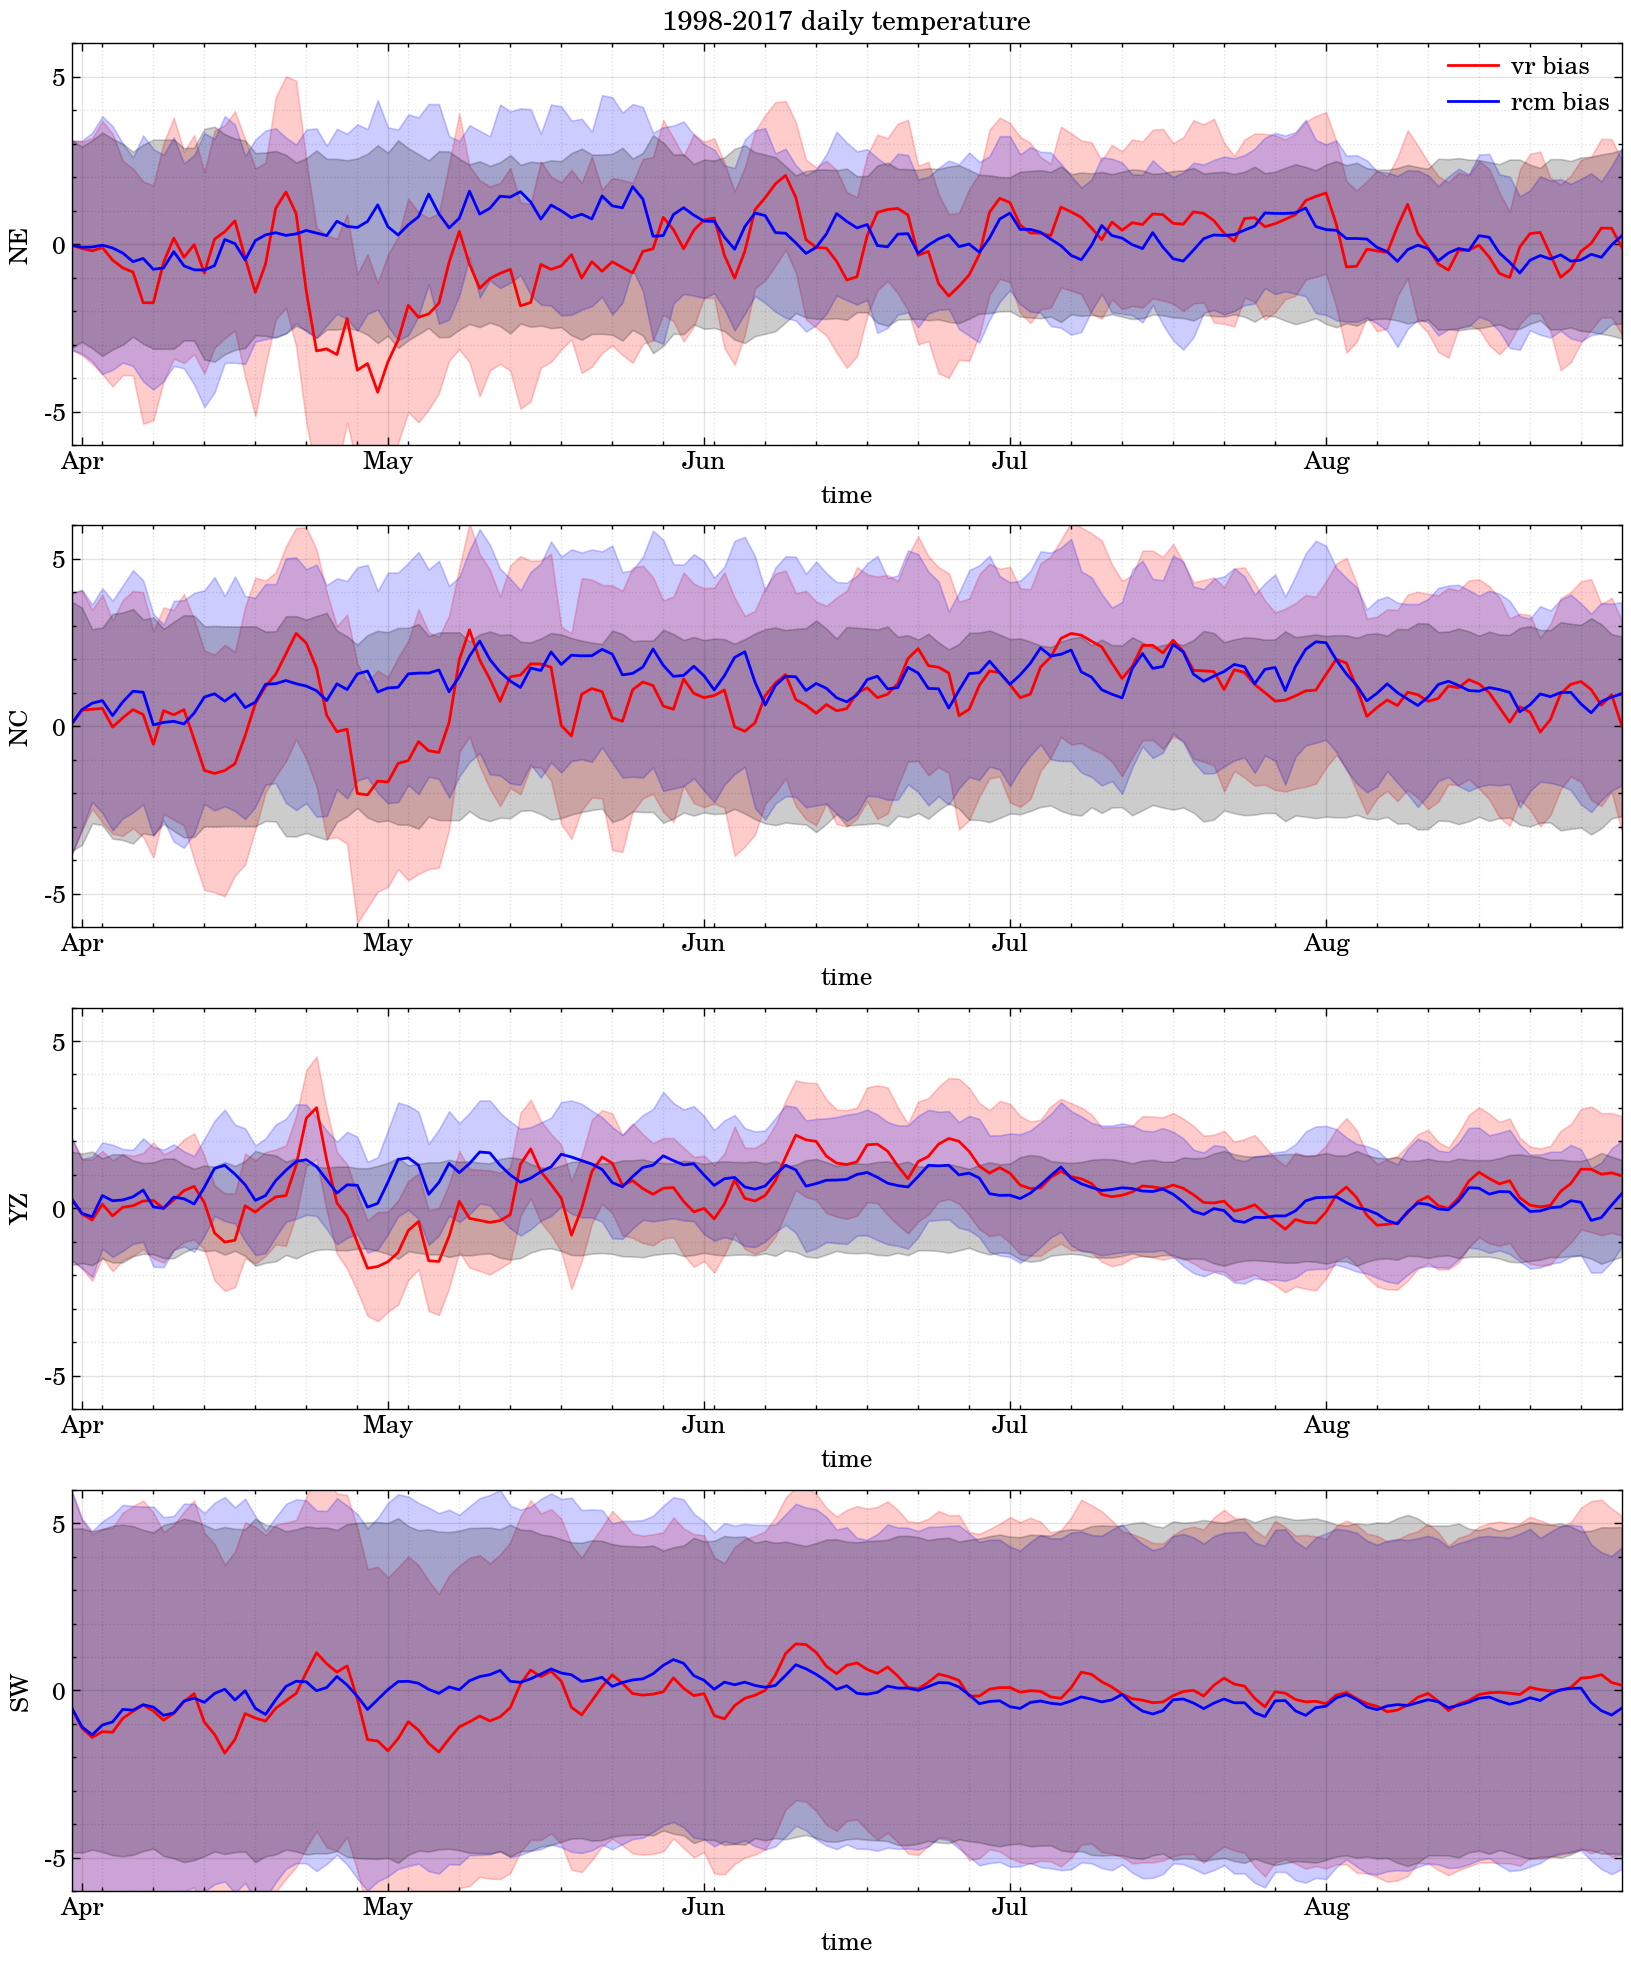

In [5]:
import matplotlib.dates as dates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

inum = 0
fig,ax = plt.subplots(4,1,figsize=(16,12))
for i in partial_list:
    plot_pd = mean_temp[i]
    std_pd  = std_temp[i]
    # pd_plot = pd.concat([df_obs, df_mod,minus], axis=1)
    ymin = -6.
    ymax = 6.
    # idx = pd.date_range("2003-"+'04-01', "2003-"+'09-01')
    # s = pd.Series(np.random.randn(len(idx)), index=idx)

    # fig, ax = plt.subplots()
    # ax.plot_date(idx.to_pydatetime(), 'v-')
    ax[inum] = plot_pd.plot(figsize=(10,12),style=['-r','-b'],ax = ax[inum])
    ax[inum].xaxis.set_minor_locator(dates.DayLocator(interval=5))
    # ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    ax[inum].fill_between(plot_pd.index, plot_pd['vr bias'].values+std_pd['vr'].values, plot_pd['vr bias'].values-std_pd['vr'].values, color = 'r', alpha = 0.2)
    ax[inum].fill_between(plot_pd.index, plot_pd['rcm bias'].values+std_pd['rcm'].values, plot_pd['rcm bias'].values-std_pd['rcm'].values, color = 'b', alpha = 0.2)
    ax[inum].fill_between(plot_pd.index, std_pd['cn051'].values, -std_pd['cn051'].values, color = 'k', alpha = 0.2)
    ax[inum].xaxis.grid(True, which="minor")
    # ax[inum].set_xlim([xmin,xmax])
    # ax[inum].yaxis.grid(True, which="minor")
    ax[inum].yaxis.grid(True, which="major")

    ax[inum].yaxis.set_major_locator(MultipleLocator(5.))
    ax[inum].yaxis.set_major_formatter(FormatStrFormatter('%1.f'))
    ax[inum].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[inum].xaxis.grid(True, which="minor", linestyle = ":")
    ax[inum].xaxis.grid(True, which="major", linestyle = "-")
    ax[inum].yaxis.grid(True, which="minor", linestyle = ":")
    ax[inum].yaxis.grid(True, which="major", linestyle = "-")
    
    ax[inum].set_ylim([ymin,ymax])
    ax[inum].set_ylabel(i)
    ax[inum].get_legend().remove()
    # plt.savefig("./output_pic/series_dayofyear.png")
    ax[inum].xaxis.set_major_locator(dates.MonthLocator())
    ax[inum].xaxis.set_major_formatter(dates.DateFormatter('%b'))
    inum = inum + 1

ax[0].legend()
ax[0].set_title("1998-2017 daily temperature")
# 背景设置为白色，否则会成为透明，png格式下
fig.patch.set_facecolor('white')
plt.savefig("./output_pic/98-17_t2m_series_dayofyear.png", dpi = 300, facecolor='white')